In [1]:
#load library
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from scipy import datasets
from openpiv.tools import imread
from pylab import *
import cv2

In [2]:
# Read the image and cut unusful points

# maximum y-coordinate
max_x = 3000
min_x=500

max_y = 1900
min_y=0


impo_a = cv2.imread('try4_exp000001.T000.D000.P000.H000.LA.TIF', cv2.IMREAD_UNCHANGED)
impo_a = impo_a[min_y:max_y, min_x:max_x]

#shifted image
impo_b= cv2.imread('try4_exp000199.T000.D000.P000.H000.LA.TIF', cv2.IMREAD_UNCHANGED)
impo_b = impo_b[min_y:max_y, min_x:max_x]

# Get image properties
#height, width = impo_a.shape[:2]
#channels = impo_a.shape[2] if len(impo_a.shape) > 2 else 1
#bit_depth = impo_a.dtype

#print("Image Properties:")
#print("Dimensions: {} x {}".format(width, height))
#print("Channels:", channels)
#print("Bit Depth:", bit_depth)
#the image has a bit depth of uint16 and we are intersted in unit8 for that a nurmalization is needed!

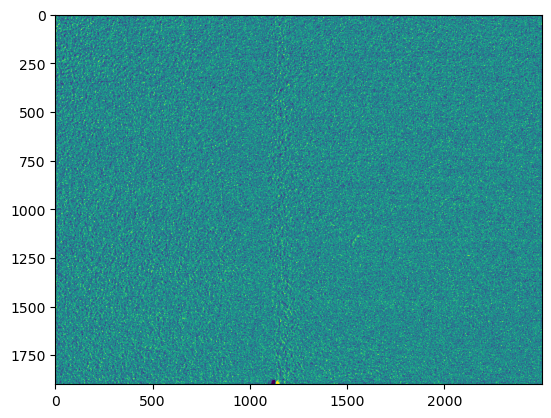

In [3]:
#difference between images
plt.imshow(impo_a-impo_b)

In [4]:
# Cell 3: Normalization
impo_a = cv2.normalize(impo_a, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image_a_mean = impo_a.astype(np.float32) - np.mean(impo_a.astype(np.float32), axis=(0, 1))

impo_b = cv2.normalize(impo_b, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image_b_mean = impo_b.astype(np.float32) - np.mean(impo_b.astype(np.float32), axis=(0, 1))


#for testing
#image_shifted_both_directions = shift(image, (100, 4))#,mode='reflect')


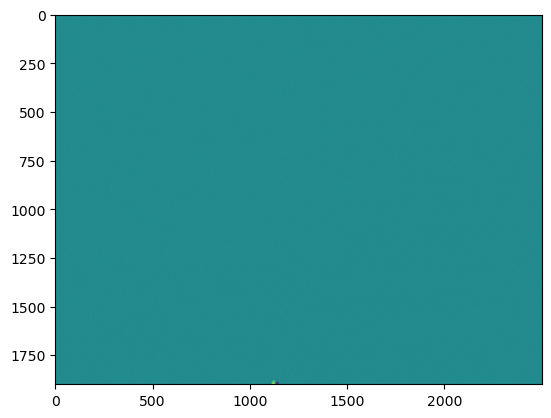

In [129]:
#difference between images#normalysation 
plt.imshow(image_a_mean - image_b_mean)

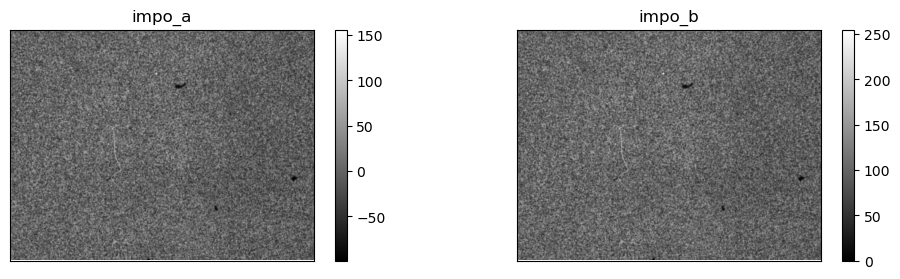

In [5]:
#plot images
# Set figure size
figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(image_a_mean, cmap='gray')
plt.title('impo_a'), plt.xticks([]), plt.yticks([])
# Add labels to the x and y axes
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
colorbar() 

# Plotting phase spectrum
plt.subplot(1, 2, 2)
plt.imshow(impo_b, cmap='gray')  # 'hsv' colormap for phase
plt.title('impo_b'), plt.xticks([]), plt.yticks([])

colorbar()


plt.show()

In [10]:
# Cell 4: correlate2d function
def correlate2d(image1, image2):
   I_1 = np.fft.rfft2(image1)
   I_2 = np.fft.rfft2(image2)
   CPS = I_1 * I_2.conjugate()
   NCPS = CPS / np.abs(CPS)
   R_1 = np.fft.fftshift(np.fft.irfft2(NCPS))
   return R_1


In [6]:
#referance image

a=image_a_mean[:, :]

#shefted image
b=image_b_mean[:, :]
b.shape 

(1900, 2500)

C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\2678045220.py:6: RuntimeWarning: invalid value encountered in divide
  NCPS = CPS / np.abs(CPS)


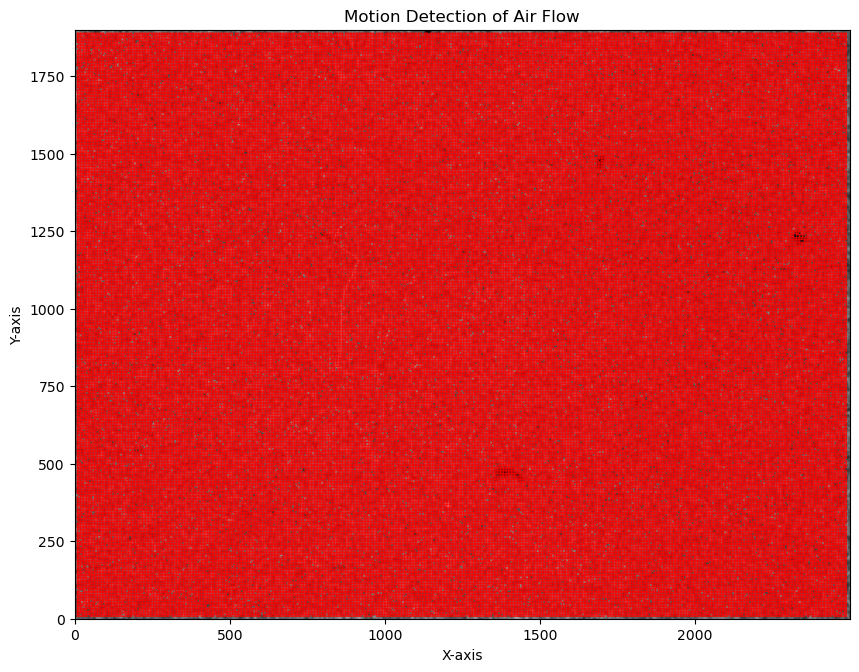

In [11]:
# Initialize lists for storing results
x, y, u, v = [], [], [], []

# Define patch size
patch_size = (16, 16)  # Further decreased patch size for increased sensitivity

# Iterate over image patches with higher overlap
for k in range(0, a.shape[0] - patch_size[0] + 1, patch_size[0] // 3):
    for m in range(0, a.shape[1] - patch_size[1] + 1, patch_size[1] // 3):
        # Extract patches from both images
        patch_a = a[k:k+patch_size[0], m:m+patch_size[1]]
        patch_b = b[k:k+patch_size[0], m:m+patch_size[1]]

        # Compute cross-correlation
        correlation = correlate2d(patch_b, patch_a)

        # Find maximum correlation location
        max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)
        i, j = max_idx[0], max_idx[1]

        # Calculate motion vector components
        u_val = j - patch_size[1] // 2
        v_val = i - patch_size[0] // 2
        motion_mag = np.sqrt(u_val**2 + v_val**2)
        u.append(u_val)
        v.append(v_val)
        x.append(m + patch_size[1] // 2)
        y.append(k + patch_size[0] // 2)

# Check if motion vectors exist before calculating the threshold
if u and v:
    # Set threshold for maximum allowable motion vector magnitude
    threshold = np.percentile(np.sqrt(np.array(u)**2 + np.array(v)**2), 99)  # Ignoring the top 1% of motion vectors

    # Filter motion vectors based on threshold
    filtered_u = [u[i] for i in range(len(u)) if np.sqrt(u[i]**2 + v[i]**2) < threshold]
    filtered_v = [v[i] for i in range(len(v)) if np.sqrt(u[i]**2 + v[i]**2) < threshold]
    filtered_x = [x[i] for i in range(len(x)) if np.sqrt(u[i]**2 + v[i]**2) < threshold]
    filtered_y = [y[i] for i in range(len(y)) if np.sqrt(u[i]**2 + v[i]**2) < threshold]

    # Calculate average motion vector magnitude for filtered vectors
    avg_magnitude = np.mean(np.sqrt(np.array(filtered_u)**2 + np.array(filtered_v)**2))

    # Plot motion vectors with increased sensitivity
    plt.figure(figsize=(10, 8))
    plt.imshow(a, cmap='gray')
    plt.quiver(filtered_x, filtered_y, filtered_u, filtered_v, color='red', scale=avg_magnitude * 15, scale_units='xy')  # Adjust scale factor for increased sensitivity
    plt.title('Motion Detection of Air Flow')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.show()
else:
    print("No motion vectors found.")

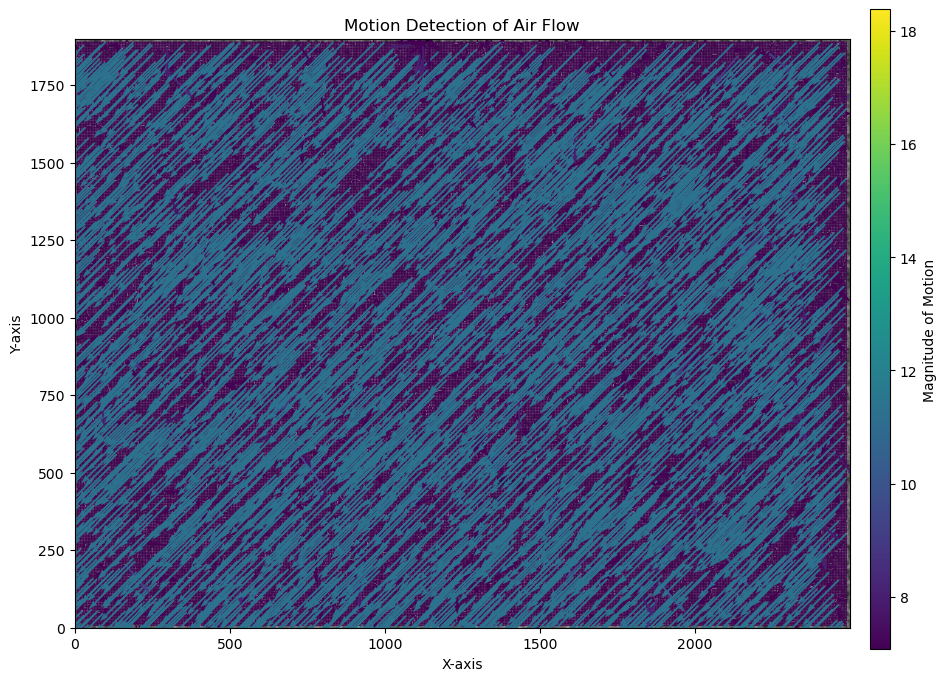

In [12]:
# Calculate magnitude of motion vectors
magnitude = np.sqrt(np.array(u)**2 + np.array(v)**2)

# Define colormap
cmap = plt.cm.viridis  

# Normalize magnitudes to range [0, 1] for colormap
#norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x, y, u, v, color=cmap(norm(magnitude)), scale=avg_magnitude, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()



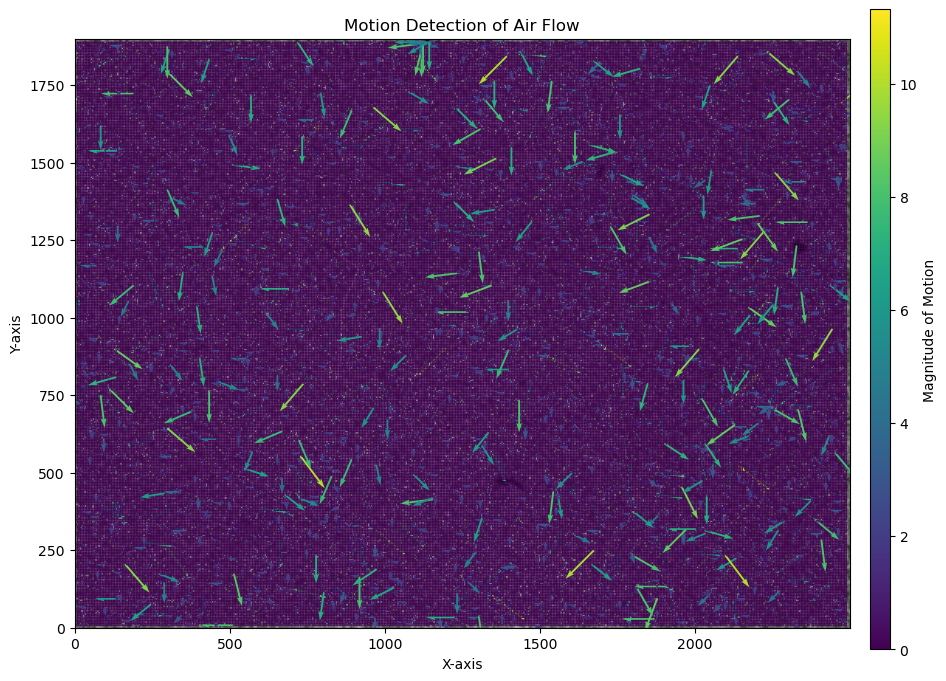

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Convert x, y, u, v to NumPy arrays if they are not already
x = np.array(x)
y = np.array(y)
u = np.array(u)
v = np.array(v)

# Calculate magnitude of motion vectors
magnitude = np.sqrt(u**2 + v**2)

# Define colormap
cmap = plt.cm.viridis  

# Normalize magnitudes to range [0, 1] for colormap
norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Filter out vectors with magnitude greater than 10
mask = magnitude <= 10
x_filtered = x[mask]
y_filtered = y[mask]
u_filtered = u[mask]
v_filtered = v[mask]
magnitude_filtered = magnitude[mask]

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x_filtered, y_filtered, u_filtered, v_filtered, color=cmap(norm(magnitude_filtered)), scale=avg_magnitude, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()



C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\2354950920.py:17: RuntimeWarning: invalid value encountered in divide
  u_normalized = (u / magnitude) * fixed_length
C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\2354950920.py:18: RuntimeWarning: invalid value encountered in divide
  v_normalized = (v / magnitude) * fixed_length


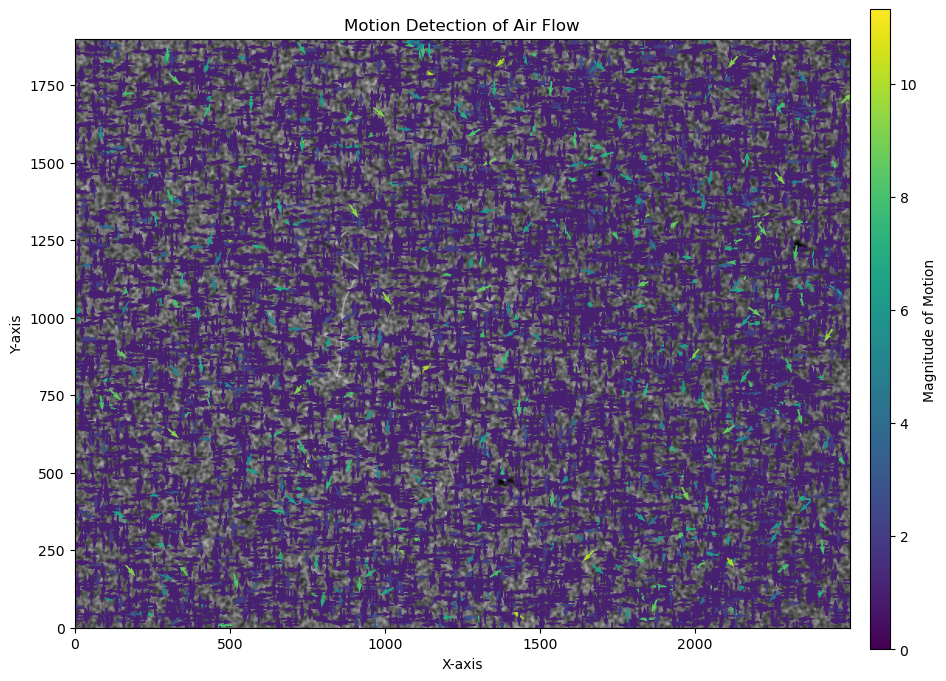

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert x, y, u, v to NumPy arrays if they are not already
x = np.array(x)
y = np.array(y)
u = np.array(u)
v = np.array(v)

# Calculate magnitude of motion vectors
magnitude = np.sqrt(u**2 + v**2)

# Define a fixed arrow length
fixed_length = 50  # You can adjust this value to change the fixed length

# Normalize vectors to the fixed length
u_normalized = (u / magnitude) * fixed_length
v_normalized = (v / magnitude) * fixed_length

# Define colormap
cmap = plt.cm.viridis  

# Normalize magnitudes to range [0, 1] for colormap
norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Filter out vectors with magnitude greater than 10
mask = magnitude <= 10
x_filtered = x[mask]
y_filtered = y[mask]
u_filtered = u_normalized[mask]
v_filtered = v_normalized[mask]
magnitude_filtered = magnitude[mask]

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x_filtered, y_filtered, u_filtered, v_filtered, color=cmap(norm(magnitude_filtered)), scale=1, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()


C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\280000740.py:17: RuntimeWarning: invalid value encountered in divide
  u_normalized = (u / magnitude) * fixed_length
C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\280000740.py:18: RuntimeWarning: invalid value encountered in divide
  v_normalized = (v / magnitude) * fixed_length


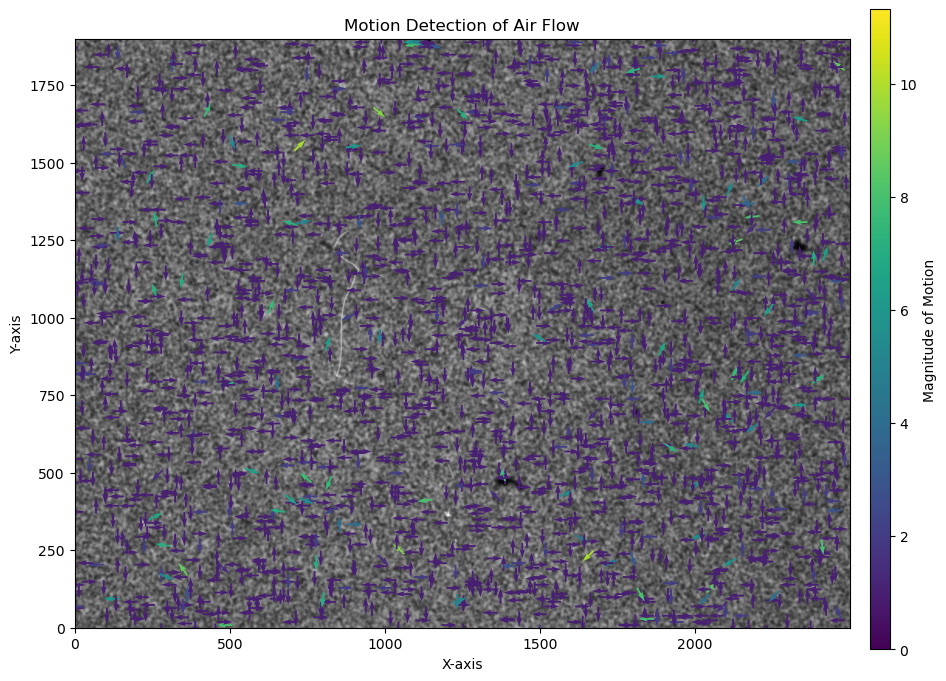

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Convert x, y, u, v to NumPy arrays if they are not already
x = np.array(x)
y = np.array(y)
u = np.array(u)
v = np.array(v)

# Calculate magnitude of motion vectors
magnitude = np.sqrt(u**2 + v**2)

# Define a fixed arrow length
fixed_length = 50  # You can adjust this value to change the fixed length

# Normalize vectors to the fixed length
u_normalized = (u / magnitude) * fixed_length
v_normalized = (v / magnitude) * fixed_length

# Define colormap
cmap = plt.cm.viridis  

# Normalize magnitudes to range [0, 1] for colormap
norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Filter out vectors with magnitude greater than 10
mask = magnitude <= 10
x_filtered = x[mask]
y_filtered = y[mask]
u_filtered = u_normalized[mask]
v_filtered = v_normalized[mask]
magnitude_filtered = magnitude[mask]

# Define step size for skipping arrows
step_size = 5  # Adjust this value to skip more or fewer arrows

# Apply step size to skip arrows
x_skipped = x_filtered[::step_size]
y_skipped = y_filtered[::step_size]
u_skipped = u_filtered[::step_size]
v_skipped = v_filtered[::step_size]
magnitude_skipped = magnitude_filtered[::step_size]

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x_skipped, y_skipped, u_skipped, v_skipped, color=cmap(norm(magnitude_skipped)), scale=1, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()


C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\974231943.py:17: RuntimeWarning: invalid value encountered in divide
  u_normalized = (u / magnitude) * fixed_length
C:\Users\PIV\AppData\Local\Temp\ipykernel_89616\974231943.py:18: RuntimeWarning: invalid value encountered in divide
  v_normalized = (v / magnitude) * fixed_length


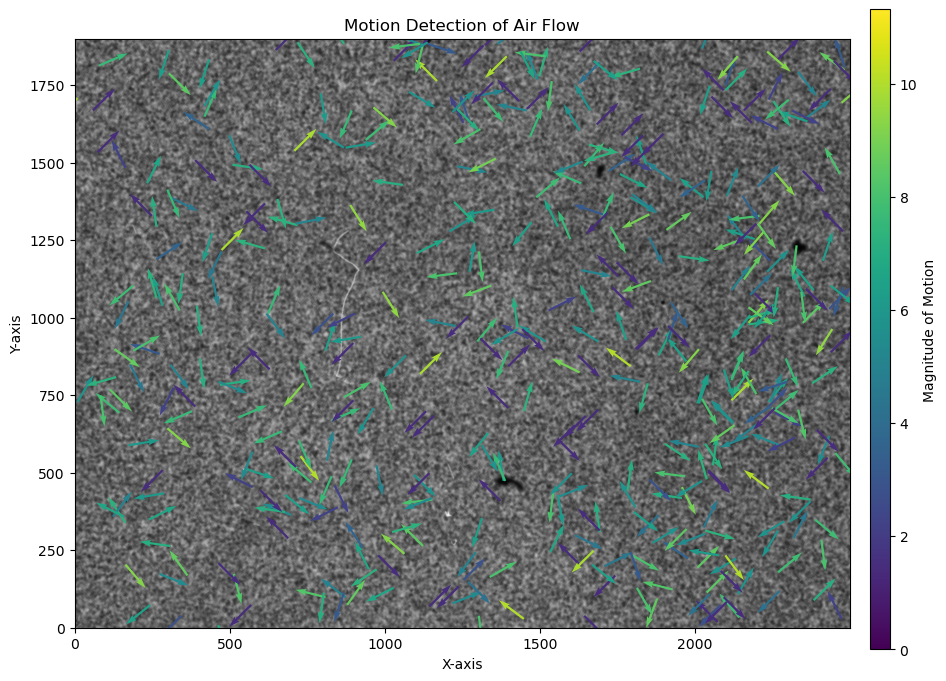

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Convert x, y, u, v to NumPy arrays if they are not already
x = np.array(x)
y = np.array(y)
u = np.array(u)
v = np.array(v)

# Calculate magnitude of motion vectors
magnitude = np.sqrt(u**2 + v**2)

# Define a fixed arrow length
fixed_length = 100  # You can adjust this value to change the fixed length

# Normalize vectors to the fixed length
u_normalized = (u / magnitude) * fixed_length
v_normalized = (v / magnitude) * fixed_length

# Define colormap
cmap = plt.cm.viridis  

# Normalize magnitudes to range [0, 1] for colormap
norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Filter out vectors with magnitude greater than 10 and zero vectors
mask = (magnitude <= 10) & (u != 0) & (v != 0)
x_filtered = x[mask]
y_filtered = y[mask]
u_filtered = u_normalized[mask]
v_filtered = v_normalized[mask]
magnitude_filtered = magnitude[mask]

# Define step size for skipping arrows
step_size = 1  # Adjust this value to skip more or fewer arrows

# Apply step size to skip arrows
x_skipped = x_filtered[::step_size]
y_skipped = y_filtered[::step_size]
u_skipped = u_filtered[::step_size]
v_skipped = v_filtered[::step_size]
magnitude_skipped = magnitude_filtered[::step_size]

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x_skipped, y_skipped, u_skipped, v_skipped, color=cmap(norm(magnitude_skipped)), scale=1, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()


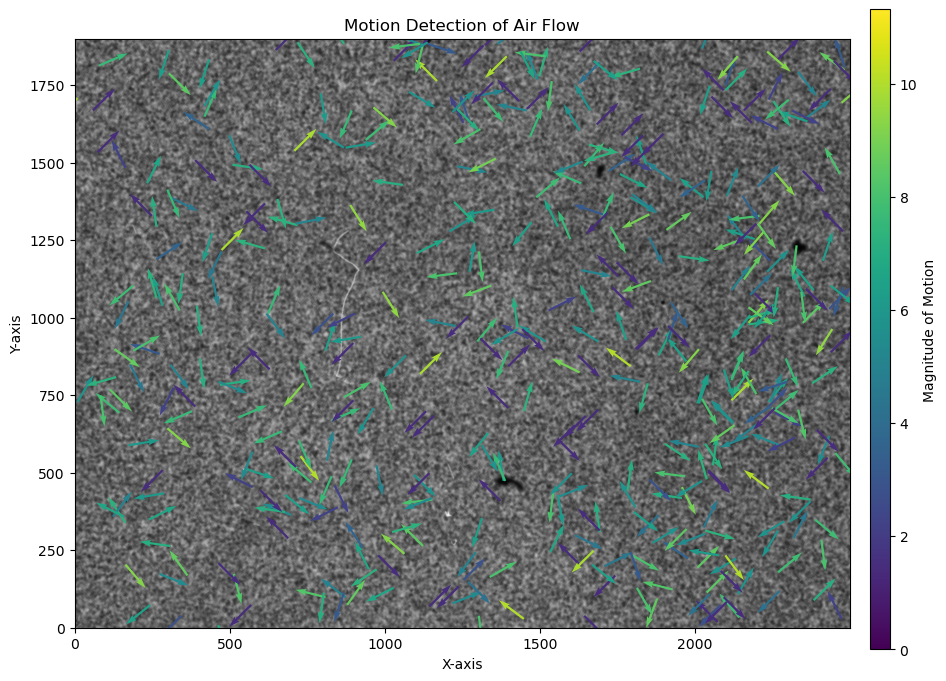

In [17]:
# Define step size for skipping arrows
step_size = 1  # Adjust this value to plot more arrows

# Apply step size to skip arrows
x_skipped = x_filtered[::step_size]
y_skipped = y_filtered[::step_size]
u_skipped = u_filtered[::step_size]
v_skipped = v_filtered[::step_size]
magnitude_skipped = magnitude_filtered[::step_size]

# Plot motion vectors with colored arrows
plt.figure(figsize=(10, 8))
plt.imshow(a, cmap='gray')
plt.quiver(x_skipped, y_skipped, u_skipped, v_skipped, color=cmap(norm(magnitude_skipped)), scale=1, scale_units='xy')
plt.title('Motion Detection of Air Flow')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation

# Add colorbar to show the correspondence between color and magnitude
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Magnitude of Motion')

plt.show()
